In [350]:
%matplotlib inline
import dataset
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')

In [351]:
df = pd.read_csv(r"C:\Users\andre\OneDrive\Documente\GitHub\Smartphone dataset price\SmartphonePriceDataset\smartphones.csv")
df['Storage'] = df['Storage'].apply(lambda x: 32 if x < 32 else x)
df.fillna(df.median(numeric_only=True), inplace=True)
bins = [60, 200, 500, 1000, 2200]
labels = ['low', 'medium', 'high', 'premium']
df['Price Category'] = pd.cut(df['Final Price'], bins=bins, labels=labels)
df



,Smartphone,Brand,Model,RAM,Storage,Color,Free,Final Price,Price Category
0,Realme C55 8/256GB Sunshower Libre,Realme,C55,8.0,256.0,Yellow,Yes,231.60,medium
1,Samsung Galaxy M23 5G 4/128GB Azul Libre,Samsung,Galaxy M23,4.0,128.0,Blue,Yes,279.00,medium
2,Motorola Moto G13 4/128GB Azul Lavanda Libre,Motorola,Moto G13,4.0,128.0,Blue,Yes,179.01,low
3,Xiaomi Redmi Note 11S 6/128GB Gris Libre,Xiaomi,Redmi Note 11S,6.0,128.0,Gray,Yes,279.99,medium
4,Nothing Phone (2) 12/512GB Blanco Libre,Nothing,Phone (2),12.0,512.0,White,Yes,799.00,high
...,...,...,...,...,...,...,...,...,...
1811,Xiaomi Redmi Note 8 4/64GB Azul Libre,Xiaomi,Redmi Note 8,4.0,64.0,Blue,Yes,249.01,medium
1812,Xiaomi Redmi Note 8T 4/128GB Azul Estelar Libre,Xiaomi,Redmi Note 8T,4.0,128.0,Blue,Yes,200.00,low
1813,Xiaomi Redmi Note 9 4/128GB Blanco Libre,Xiaomi,Redmi Note 9,4.0,128.0,White,Yes,269.00,medium
1814,Xiaomi Redmi Note 9S 4/64GB Dual SIM Gris Libre,Xiaomi,Note 9S,4.0,64.0,Gray,Yes,211.00,medium


In [352]:
Q1 = df['Final Price'].quantile(0.25)
Q3 = df['Final Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['Final Price'] >= lower_bound) & (df['Final Price'] <= upper_bound)]


In [353]:
text = '''Datasetul este format din 1816 randuri si este pe 9 coloane:
1. Numele Smartphone-ului
2. Modelul
3. RAM (Memorie cu Acces Aleator)
4. Spatiul de Stocare
5. Culoare
6. Free (indica daca are sau nu un contract cu o companie de telefonie mobila)
7. Pretul smartphone-ului
8. Categorie de Pret : consta luxul telefonului bazat pe intru-n interval de pret
idei-------------------:Numar de vanzari'''

print(text)


Datasetul este format din 1816 randuri si este pe 9 coloane:
1. Numele Smartphone-ului
2. Modelul
3. RAM (Memorie cu Acces Aleator)
4. Spatiul de Stocare
5. Culoare
6. Free (indica daca are sau nu un contract cu o companie de telefonie mobila)
7. Pretul smartphone-ului
8. Categorie de Pret : consta luxul telefonului bazat pe intru-n interval de pret
idei-------------------:Numar de vanzari


In [354]:
print(f"Numar de randuri: {df.shape[0]}")
print(f"Numar de coloane: {df.shape[1]}")

Numar de randuri: 1722
Numar de coloane: 9


In [355]:
print("Coloanele datasetului sunt:")
print(df.columns)
print("\n")
print("Tipurile de dataset-ului :\n")
print(df.dtypes)
print("\n")
print(df.describe())
print("\n")

print("Valori Not A Number : ")
print(df.isnull().sum())
print(df.describe())


Coloanele datasetului sunt:
Index(['Smartphone', 'Brand', 'Model', 'RAM', 'Storage', 'Color', 'Free',
       'Final Price', 'Price Category'],
      dtype='object')


Tipurile de dataset-ului :

Smartphone          object
Brand               object
Model               object
RAM                float64
Storage            float64
Color               object
Free                object
Final Price        float64
Price Category    category
dtype: object


               RAM      Storage  Final Price
count  1722.000000  1722.000000  1722.000000
mean      5.901278   145.119628   430.052178
std       2.257046   101.003683   300.486656
min       1.000000    32.000000    60.460000
25%       4.000000    64.000000   199.000000
50%       6.000000   128.000000   327.990000
75%       8.000000   256.000000   589.000000
max      12.000000  1000.000000  1326.030000


Valori Not A Number : 
Smartphone        0
Brand             0
Model             0
RAM               0
Storage           0
Color           

In [356]:

plt.figure(figsize=(8, 6))
df['Final Price'].hist(bins=30, edgecolor='black')
plt.title('Distributia Preturilor')
plt.xlabel('Final Price')
plt.ylabel('Frecventa')
plt.show(block=True)


In [357]:
def gini_index(data, target_column):
    class_counts = data[target_column].value_counts(normalize=True)
    gini = 1 - sum(class_counts**2)
    return gini

gini = gini_index(df, 'Price Category')
print(f"Gini Index pentru 'Price Category': {gini}")

Gini Index pentru 'Price Category': 0.6860192817956055


In [358]:
def gini_for_attribute(data, attribute, target_column):
    grouped = data.groupby(attribute)
    gini_values = {}

    for group, subset in grouped:
        gini_values[group] = gini_index(subset, target_column)

    return gini_values

gini_values_for_brand = gini_for_attribute(df, 'Brand', 'Price Category')
print("Gini Index pentru fiecare brand:", gini_values_for_brand)

Gini Index pentru fiecare brand: {'Alcatel': 0.24489795918367352, 'Apple': 0.7097875828153815, 'Asus': 0.6666666666666667, 'BQ': 0.0, 'Blackview': 0.49382716049382713, 'CAT': 0.6111111111111112, 'Crosscall': 0.48979591836734704, 'Cubot': 0.4377162629757785, 'Doro': 0.4444444444444444, 'Fairphone': 0.0, 'Funker': 0.0, 'Gigaset': 0.4444444444444444, 'Google': 0.6666666666666667, 'Hammer': 0.5804988662131519, 'Honor': 0.470414201183432, 'Huawei': 0.5921822099107419, 'LG': 0.0, 'Lenovo': 0.0, 'Maxcom': 0.0, 'Microsoft': 0.0, 'Motorola': 0.6531240381655894, 'Nokia': 0.5416666666666666, 'Nothing': 0.19753086419753085, 'OPPO': 0.6304347826086957, 'OnePlus': 0.48979591836734704, 'POCO': 0.4219202494987747, 'Qubo': 0.0, 'Realme': 0.5785667324128863, 'SPC': 0.0, 'Samsung': 0.6931721737743577, 'Sony': 0.5, 'Swissvoice': 0.0, 'TCL': 0.4521604938271605, 'Ulefone': 0.5711111111111111, 'Vivo': 0.5898491083676268, 'Xiaomi': 0.6021461235950445, 'ZTE': 0.0}


In [359]:
import numpy as np

def entropy(data):
    class_counts = data['Price Category'].value_counts(normalize=True)

    class_counts = class_counts[class_counts > 0]
    return -np.sum(class_counts * np.log2(class_counts))

parent_entropy = entropy(df)
print(f"Entropia pentru intregul set de date: {parent_entropy}")


Entropia pentru intregul set de date: 1.7928240994534357


In [360]:
# Functie pentru calcularea Information Gain pe baza unui atribut
def information_gain(data, attribute):
    parent_entropy = entropy(data)

    grouped = data.groupby(attribute)
    weighted_entropy = 0
    for group, subset in grouped:
        weighted_entropy += (len(subset) / len(data)) * entropy(subset)
    return parent_entropy - weighted_entropy

info_gain = information_gain(df, 'Brand')
print(f"Information Gain pentru 'Brand': {info_gain}")
info_gain = information_gain(df, 'Storage')
print(f"Information Gain pentru 'Storage': {info_gain}")
info_gain = information_gain(df, 'RAM')
print(f"Information Gain pentru 'RAM': {info_gain}")
info_gain = information_gain(df, 'Brand')
print(f"Information Gain pentru 'Brand': {info_gain}")

Information Gain pentru 'Brand': 0.26251049121179326
Information Gain pentru 'Storage': 0.3982473850517898
Information Gain pentru 'RAM': 0.42673224769343276
Information Gain pentru 'Brand': 0.26251049121179326


In [361]:
# Calcularea corelatiei dintre 'Final Price' și 'RAM','Storage'
correlation = df['Final Price'].corr(df['Storage'])
print(f"Corelatia dintre 'Final Price' si 'Storage': {correlation}")
correlation = df['Final Price'].corr(df['RAM'])
print(f"Corelatia dintre 'Final Price' si 'RAM': {correlation}")

Corelatia dintre 'Final Price' si 'Storage': 0.5821433839604104
Corelatia dintre 'Final Price' si 'RAM': 0.4946746366627295


In [362]:
numeric_columns = df.select_dtypes(include=['number'])
numeric_columns

,RAM,Storage,Final Price
0,8.0,256.0,231.60
1,4.0,128.0,279.00
2,4.0,128.0,179.01
3,6.0,128.0,279.99
4,12.0,512.0,799.00
...,...,...,...
1811,4.0,64.0,249.01
1812,4.0,128.0,200.00
1813,4.0,128.0,269.00
1814,4.0,64.0,211.00


In [363]:
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [364]:
# Codificarea Brand-ului cu LabelEncoder
label_encoder = LabelEncoder()
df.loc[:, 'Brand'] = label_encoder.fit_transform(df['Brand'])

X = df[['RAM', 'Storage', 'Brand']]
y = df['Final Price']

# Imparțirea datelor in seturi de antrenament si test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizarea datelor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crearea modelului de regresie liniara
model = LinearRegression()

# Antrenarea modelului
model.fit(X_train_scaled, y_train)

# Predictiile pe setul de test
y_pred = model.predict(X_test_scaled)

# Evaluarea performantei
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Coefficients și interceptul
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")


RMSE: 230.10693633259987
R²: 0.38776195759431
Coefficients: [ 79.09454916 125.64930835 -66.13554459]
Intercept: 430.8810167029775


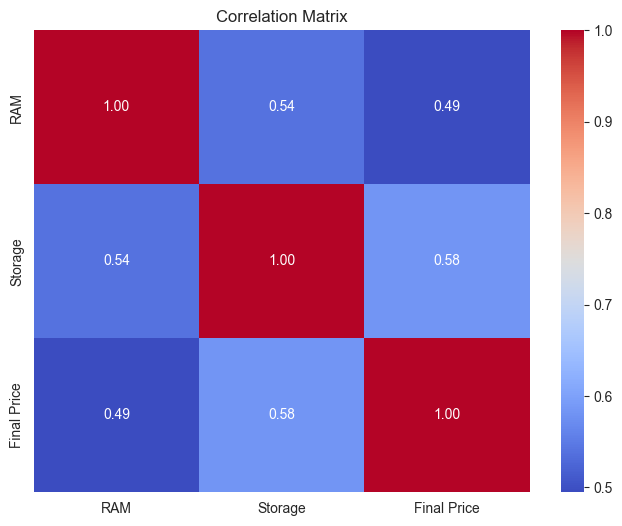

RMSE: 230.10693633259987
R²: 0.38776195759431
Coefficients: [ 79.09454916 125.64930835 -66.13554459]
Intercept: 430.8810167029775


In [365]:
from IPython.display import display
display(plt.gcf())

# Codificarea Brand-ului cu LabelEncoder
label_encoder = LabelEncoder()
df.loc[:, 'Brand'] = label_encoder.fit_transform(df['Brand'])

X = df[['RAM', 'Storage', 'Brand']]
y = df['Final Price']

# Impartirea datelor in seturi de antrenament si test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizarea datelor
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crearea modelului de regresie liniara
model = LinearRegression()

# Antrenarea modelului
model.fit(X_train_scaled, y_train)

# Predictiile pe setul de test
y_pred = model.predict(X_test_scaled)

# Evaluarea performantei
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Afisarea performantei
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

# Coefficients
print(f"Coefficients: {model.coef_}")
print(f"Intercept: {model.intercept_}")

In [366]:
# 1. Real vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Real vs Predicted Final Price')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()

# 2. Residual Plot
plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred, y=y_test - y_pred, color='purple')
plt.title('Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


In [367]:
from sklearn.ensemble import RandomForestRegressor

# Crearea si antrenarea modelului Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predictiile pentru setul de test
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluarea performantei modelului Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Afisarea performantei modelului Random Forest
print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest R²: {r2_rf}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, color='green', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Random Forest: Real vs Predicted Final Price')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred_rf, y=y_test - y_pred_rf, color='orange')
plt.title('Random Forest: Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


Random Forest RMSE: 188.7653350359307
Random Forest R²: 0.5879922572419309


In [368]:

# Crearea si antrenarea modelului XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predictiile pentru setul de test
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluarea performantei modelului XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

# Afisarea performaantei modelului XGBoost
print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R²: {r2_xgb}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, color='red', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')
plt.title('XGBoost: Real vs Predicted Final Price')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.residplot(x=y_pred_xgb, y=y_test - y_pred_xgb, color='blue')
plt.title('XGBoost: Residual Plot')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()


XGBoost RMSE: 188.4150143233719
XGBoost R²: 0.5895200898163502


In [369]:
# Compararea RMSE si R² ale fiecarui model
models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_values = [rmse, rmse_rf, rmse_xgb]
r2_values = [r2, r2_rf, r2_xgb]

comparison_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'R²': r2_values
})

print(comparison_df)


               Model        RMSE        R²
0  Linear Regression  230.106936  0.387762
1      Random Forest  188.765335  0.587992
2            XGBoost  188.415014  0.589520


In [370]:
text = '''Dupa parerea mea cel mai bun algoritm pe care il pot folosi in momentul de fata este "XGBoost  188.415014  0.589520" '''

print(text)


Dupa parerea mea cel mai bun algoritm pe care il pot folosi in momentul de fata este "XGBoost  188.415014  0.589520" 


In [371]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Set de hiperparametri pentru cautare
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Model de baza
xgb = XGBRegressor(random_state=42)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Antrenarea cu datele standardizate
random_search.fit(X_train_scaled, y_train)

# Cel mai bun model
best_xgb = random_search.best_estimator_

# Evaluarea pe setul de test
y_pred_best = best_xgb.predict(X_test_scaled)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("Cei mai buni hiperparametri:", random_search.best_params_)
print(f"RMSE optimizat: {rmse_best}")
print(f"R² optimizat: {r2_best}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Cei mai buni hiperparametri: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
RMSE optimizat: 190.68768433191278
R² optimizat: 0.5795579152396295


In [372]:
from sklearn.neighbors import KNeighborsRegressor

# Codificare labeluri
label_encoder = LabelEncoder()
df.loc[:, 'Brand'] = label_encoder.fit_transform(df['Brand'])

# Definirea X și y
X = df[['RAM', 'Storage', 'Brand']]
y = df['Final Price']

# imparțire si scalare
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dicționar modele
models = {
    "Linear Regression": LinearRegression(),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "XGBoost Optimized": XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5,
                                      subsample=0.8, colsample_bytree=1.0, random_state=42)
}

# Rezultate
results = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({
        "Model": name,
        "RMSE": round(rmse, 2),
        "R²": round(r2, 4)
    })

# DataFrame cu rezultate
results_df = pd.DataFrame(results)
print(results_df.sort_values(by="RMSE"))


               Model    RMSE      R²
3            XGBoost  188.42  0.5895
2      Random Forest  188.77  0.5880
4  XGBoost Optimized  190.69  0.5796
1                KNN  191.81  0.5746
0  Linear Regression  230.11  0.3878


In [373]:
text = '''Am ales dupa cel care se prezinta mai bine la RMSE si la R2 acel algoritm fiind XGBoost '''

print(text)

Am ales dupa cel care se prezinta mai bine la RMSE si la R2 acel algoritm fiind XGBoost 
